In [1]:
import cProfile
import pstats
import sys
from pstats import SortKey

import numpy as np
import pandas as pd
from river.decomposition import OnlineSVD, OnlineDMDwC
from river.preprocessing import Hankelizer
from river.utils import Rolling

Rolling.learn_one = Rolling.update  # type: ignore
sys.path.append("../")

from functions.chdsubid import SubIDChangeDetector  # noqa: E402
from functions.datasets import load_cats  # noqa: E402
from functions.evaluate import evaluate  # noqa: E402
from functions.plot import plot_chd  # noqa: E402
from functions.preprocessing import hankel  # noqa: E402

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Read data
df = load_cats("data/cats/data_1t_agg_last.csv")
df.index = pd.to_datetime(df.index)
U = df[["aimp", "amud", "adbr", "adfl"]]
X = df[
    [
        "bed1",
        "bed2",
        "bfo1",
        "bfo2",
        "bso1",
        "bso2",
        "bso3",
        "ced1",
        "cfo1",
        "cso1",
    ]
]
Y_true = df.pop("y")
Y_cat = df.pop("category")

Processed 83000/83334

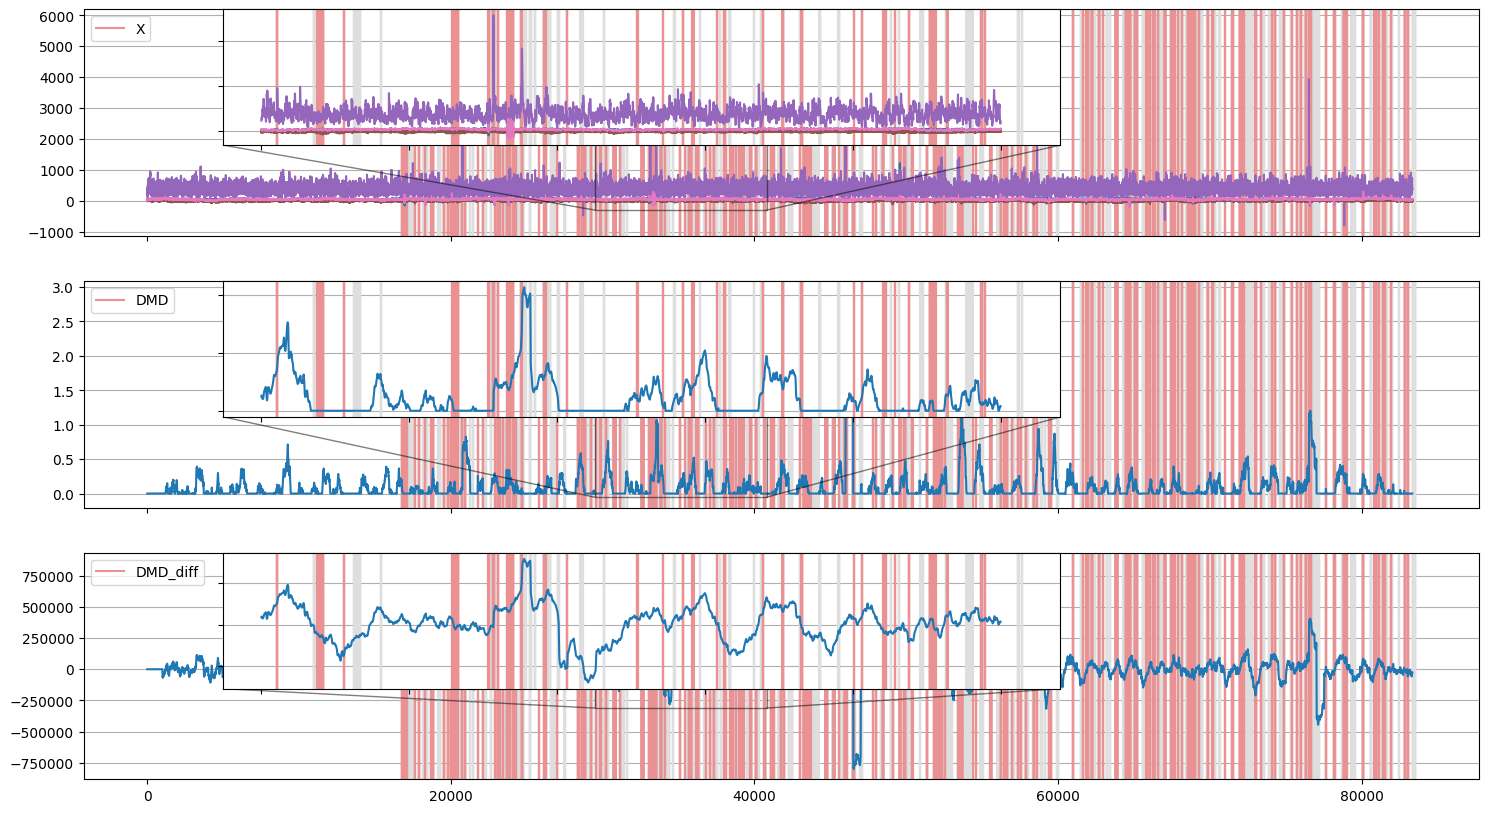

In [4]:
# [donotremove]
# TODO: enable hankelization of us on the fly
hu = 1
U_ = hankel(U, hn=hu)

# Initialize Hankelizer
hn = 2
hankelizer = Hankelizer(hn)

# Initialize Transformer
p = 1
q = 1
init_size = 500
odmd = Rolling(
    OnlineDMDwC(
        p=p,
        q=q,
        initialize=init_size,
        w=1.0,
        exponential_weighting=False,
        eig_rtol=1e-3,
    ),
    init_size + 1,
)
window_size = init_size + 1
osvd = Rolling(
    OnlineSVD(
        n_components=p,
        initialize=init_size,
    ),
    init_size + 1,
)

# Initialize Change-Point Detector
ref_size = init_size
test_size = init_size
subid_dmd = SubIDChangeDetector(
    odmd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)
subid_svd = SubIDChangeDetector(
    osvd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)

# Build pipeline
pipeline_dmd = hankelizer | subid_dmd
pipeline_svd = Hankelizer(hn) | subid_svd

# Prepare arrays for storing results
scores_dmd = np.zeros(X.shape[0], dtype=float)
# scores_svd = np.zeros(X.shape[0], dtype=float)
scores_dmd_diff = np.zeros(X.shape[0], dtype=complex)
dist = np.zeros((X.shape[0], 2), dtype=complex)
modes = np.empty((X.shape[0], hn * X.shape[1], p), dtype=complex)

# Run pipeline
for i, ((t, x), (t, u)) in enumerate(
    zip(
        X.iterrows(),
        U_.iterrows(),
    )
):
    # print every 1000
    if (i + 1) % 1000 == 0:
        print(f"\rProcessed {i + 1}/{len(X)}", end="")

    pipeline_dmd.learn_one(x.to_dict(), **{"u": u.to_dict()})
    # pipeline_svd.learn_one(x.to_dict())

    scores_dmd[i] = subid_dmd.score
    # scores_svd[i] = subid_svd.score
    if hasattr(subid_dmd.subid, "modes"):
        modes[i, :, :] = odmd.modes
    if hasattr(subid_dmd, "distances"):
        dist[i, :] = subid_dmd.distances

    scores_dmd_diff[i] = dist[i, 1] - dist[i, 0]

# Plot results
X_ = df.values
Y_ = Y_true.values
fig, axs = plot_chd(
    [X_, scores_dmd.real, scores_dmd_diff.real],
    np.where(Y_ == 1)[0],
    labels=["X", "DMD", "DMD_diff", "SVD"],
    idx_in_start=30000,
    idx_in_end=40000,
    grace_period=test_size,
)
fig_name = (
    f"results/.cats/cats-chd_p{p}_q{q}-"
    f"{f'roll_{odmd.window_size}' if isinstance(odmd, Rolling) else 'noroll'}-"
    f"dmd_w{odmd.w}-hx{hn}-hu{hu}-imag.png"
)
fig.set_size_inches(18, 10)  # Set the size of the figure
fig.savefig(fig_name)

In [353]:
pred_shift = 1
y_true = pd.Series(Y_[:-pred_shift])
y_true.index = pd.to_datetime(y_true.index, unit="s")

y_pred = pd.Series(scores_dmd[pred_shift:] > 0.05)
y_pred.index = pd.to_datetime(y_pred.index, unit="s")

In [354]:
binary = evaluate(y_true, y_pred, metric="binary")

False Alarm Rate 38.61 %
Missing Alarm Rate 55.05 %
F1 metric 0.08


In [355]:
# average detection delay metric calculation
add = evaluate(
    y_true,
    y_pred,
    metric="average_time",
    window_width=f"{init_size}s",
    anomaly_window_destination="righter",
    portion=1,
)

Amount of true anomalies 3181
A number of missed CPs = 1663
A number of FPs = 8783
Average time 0 days 00:00:04.284584980


In [356]:
# nab metric calculation
nab = evaluate(
    y_true,
    y_pred,
    metric="nab",
    window_width=f"{init_size}s",
    anomaly_window_destination="righter",
)

Standard  -  32.03
LowFP  -  16.8
LowFN  -  37.26


# Time Profiling to Reveal the Main Bottlenecks

In [ ]:
def simulate():
    # Initialize Hankelizer
    hn = 80
    hankelizer = Hankelizer(hn)

    # Initialize Transformer
    r = 10
    init_size = 300
    odmd = Rolling(
        OnlineDMDwC(
            p=r,
            q=4,
            initialize=init_size,
            w=1.0,
            exponential_weighting=False,
            eig_rtol=1e-1,
        ),
        init_size + 1,
    )

    # Initialize Change-Point Detector
    ref_size = 200
    test_size = 200
    subid_dmd = SubIDChangeDetector(
        odmd,
        ref_size=ref_size,
        test_size=test_size,
        grace_period=init_size + test_size + 1,
    )

    # Build pipeline
    pipeline_dmd = hankelizer | subid_dmd

    # Prepare arrays for storing results
    scores_dmd = np.zeros(X.shape[0], dtype=float)

    # Run pipeline
    for i, (_, x) in enumerate(df.iterrows()):
        # print every 1000
        if i % 1000 == 0:
            print(f"\rProcessed {i}/{len(df)}", end="")

        pipeline_dmd.learn_one(x.to_dict(), **{"u": u.to_dict()})

        scores_dmd[i] = subid_dmd.score


cProfile.run("simulate()", ".stats_new")

In [ ]:
p = pstats.Stats(".stats_new")
p.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats()